# Single and Combined Traditional ML Models for Offensive  Tweets Classification

## 1. Setup

In [ ]:
!pip install numpy pandas matplotlib nltk seaborn contractions scikit-learn tabulate

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import random
import seaborn as sns
import contractions
from tabulate import tabulate


In [109]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [110]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [111]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time

### 1.2 Mounting google drive

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Exploration and Data Loading

### 2.1. Access OLID Dataset

In [113]:
# accessing the dataset file path
olid_dataset_file_path = '/content/drive/MyDrive/Data_Science/NLP/CW_1/OLIDv1.0/olid-training-v1.0.tsv'

# verify that file is exists or not
if os.path.exists(olid_dataset_file_path):
    print("OLID dataset found !!")
else :
    print("OLID dataset doesn't exist !!")


OLID dataset found !!


In [114]:
olid_dataset = pd.read_csv(olid_dataset_file_path,delimiter = '\t')

### 2.2. EDA

#### 2.2.1. Accesng dataset and get insights of dataset

In [115]:
olid_dataset.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [116]:
olid_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


#### 2.2.2. Get distribution idea of subtask_a

- Count the Offensive and Non-Offensive subtask values
- Count the Targeted or Not-Targeted subtask values

In [117]:
olid_dataset['subtask_a'].value_counts()

,count
subtask_a,
NOT,8840
OFF,4400


In [118]:

def plot_bar_chart(task_name,task_data,task_colors = ['red', 'blue']):
  plt.bar(task_data.index, task_data.values, color=task_colors)
  plt.title(task_name)
  plt.xlabel('task_classes')
  plt.ylabel('No. of Tweets ')
  plt.show()

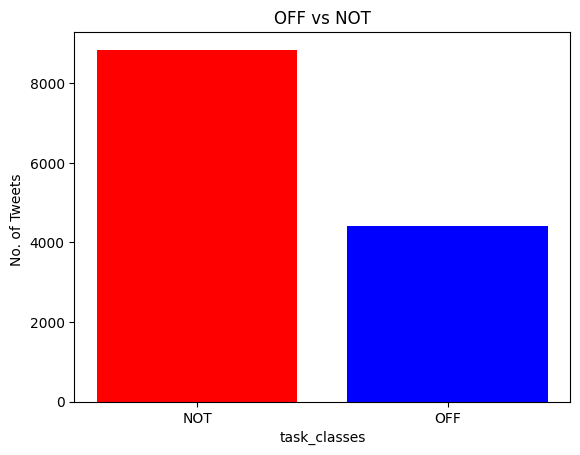

In [119]:
off_not_task_data = olid_dataset['subtask_a'].value_counts()
plot_bar_chart(task_name = "OFF vs NOT",task_data = off_not_task_data)

#### 2.2.3. Get the mention insights from dataset


In [120]:
olid_dataset['mentions_in_tweet'] = olid_dataset['tweet'].apply(lambda x : re.findall(r'@\w+', x))

olid_dataset.sample(5)

,id,tweet,subtask_a,subtask_b,subtask_c,mentions_in_tweet
7302,51044,@USER #LyingLiberals as usual. Put a republica...,OFF,UNT,NaN,[@USER]
5975,75399,@USER Character of a crook better off using Di...,NOT,NaN,NaN,[@USER]
147,68629,@USER Let the leftist democrats riot in the st...,OFF,TIN,IND,[@USER]
7307,15243,@USER CONSERVATIVES ARE CREEPY COWARDS URL,NOT,NaN,NaN,[@USER]
8516,56610,@USER who said Canada even wants him? we have ...,NOT,NaN,NaN,[@USER]


In [121]:
# find unique mention
all_mentions_in_dataset = olid_dataset['mentions_in_tweet'].explode()

len(set(all_mentions_in_dataset.dropna()))

1

In [122]:
set(all_mentions_in_dataset.dropna())

{'@USER'}

#### 2.2.4. Get the hashtags insights from dataset


In [123]:
olid_dataset['hashtags_in_tweet'] = olid_dataset['tweet'].apply(lambda x : re.findall(r'#\w+', x))

olid_dataset.head(5)

,id,tweet,subtask_a,subtask_b,subtask_c,mentions_in_tweet,hashtags_in_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,[@USER],[]
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"[@USER, @USER, @USER]","[#MAGA, #Trump2020]"
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,[],"[#Amazon, #MAGA, #KAG, #CHINA, #TCOT]"
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,[@USER],[]
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"[@USER, @USER]",[]


In [124]:
# find unique mention
all_hashtags_in_dataset = olid_dataset['hashtags_in_tweet'].explode().dropna()

len(set(all_hashtags_in_dataset))

2385

In [125]:
random.sample(list(all_hashtags_in_dataset),5)

['#DemocraticParty', '#MAGA', '#MeToo', '#MAGA', '#PatriotsUnited']

In [126]:
hashtag_counts = olid_dataset.explode('hashtags_in_tweet').groupby(['subtask_a', 'hashtags_in_tweet']).size().reset_index(name='hashtags_count')

top_offensive_hashtags = hashtag_counts[hashtag_counts['subtask_a'] == 'OFF'].nlargest(10, 'hashtags_count')
top_non_offensive_hashtags = hashtag_counts[hashtag_counts['subtask_a'] == 'NOT'].nlargest(10, 'hashtags_count')

top_hashtags_in_dataset = pd.concat([top_offensive_hashtags, top_non_offensive_hashtags])

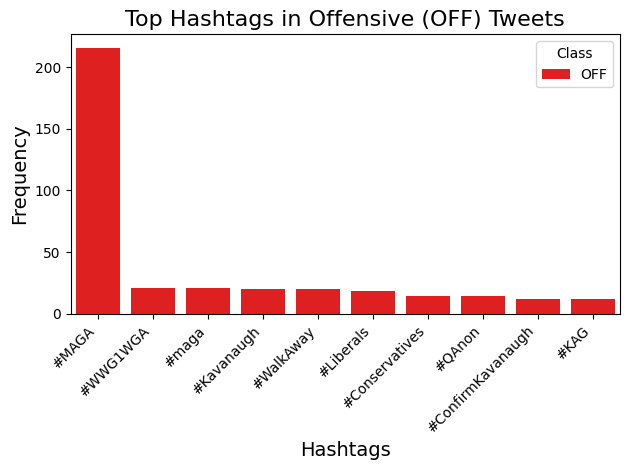

In [127]:
sns.barplot(data=top_offensive_hashtags, x='hashtags_in_tweet', y='hashtags_count', hue='subtask_a', palette=['red'])
plt.title('Top Hashtags in Offensive (OFF) Tweets', fontsize=16)
plt.xlabel('Hashtags', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

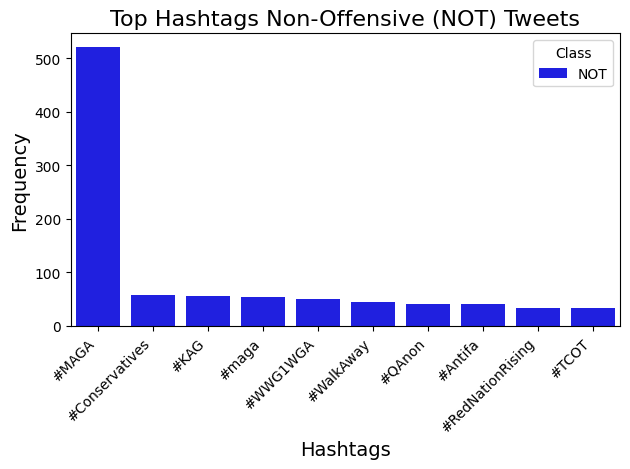

In [128]:
sns.barplot(data=top_non_offensive_hashtags, x='hashtags_in_tweet', y='hashtags_count', hue='subtask_a', palette=[ 'blue'])
plt.title('Top Hashtags Non-Offensive (NOT) Tweets', fontsize=16)
plt.xlabel('Hashtags', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

#### 2.2.5. HTML entities in dataset

In [129]:
olid_dataset['html_entities_in_tweet'] = olid_dataset['tweet'].apply(lambda x : re.findall(r'&\w+;', x))

olid_dataset.head(5)

,id,tweet,subtask_a,subtask_b,subtask_c,mentions_in_tweet,hashtags_in_tweet,html_entities_in_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,[@USER],[],[]
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"[@USER, @USER, @USER]","[#MAGA, #Trump2020]",[]
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,[],"[#Amazon, #MAGA, #KAG, #CHINA, #TCOT]",[]
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,[@USER],[],[]
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"[@USER, @USER]",[],[&amp;]


In [130]:
# find unique HTML entities
all_html_entities_in_dataset = olid_dataset['html_entities_in_tweet'].explode()

len(set(all_html_entities_in_dataset.dropna()))

3

In [131]:
set(all_html_entities_in_dataset.dropna())

{'&amp;', '&gt;', '&lt;'}

#### 2.2.6. Word Count

In [132]:
olid_dataset['word_count'] = olid_dataset['tweet'].apply(lambda x: len(str(x).split()))

In [133]:
olid_dataset['word_count'].sum()

295354

#### 2.2.7.Avarage Word Length

In [134]:
all_words = " ".join(olid_dataset['tweet'].astype(str)).split()

# Calculate average word length
average_word_length = sum(len(word) for word in all_words) / len(all_words)

print("Average Word Length for the entire dataset:", average_word_length)

Average Word Length for the entire dataset: 4.670341353088158


## 3. Data Preprocessing

1. Null values removal
2. remove duplicates
3. remove all mentions
4. remove all hashtags
5. remove html entities
6. remove digits
7. remove emojies
8. URL removal
9. Slang removal
10. Text Normalization
11. Punctuation Removal
12. Tokenization
13. Stopword Removal
14. Lemmetization
15. Detokenization
16. Lowercasing
17. Extra Feature Reduction
18. Reordering

In [135]:
class TextPreprocessor:
    """
    A comprehensive text preprocessing class that performs a series of cleaning
    and normalization operations on text data.
    """

    def __init__(self, text_column='tweet', target_columns=None):

        self.text_column = text_column
        self.target_columns = target_columns

        # Default slang dictionary if none provided
        self.slang_dict ={
            'u': 'you', 'ur': 'your', 'r': 'are', '2': 'to', '4': 'for',
            'b': 'be', 'y': 'why', 'im': 'i am', 'dm': 'direct message',
            'idk': 'i do not know', 'bc': 'because', 'rn': 'right now',
            'af': 'as fuck', 'tbh': 'to be honest', 'imo': 'in my opinion',
            'lol': 'laugh out loud', 'wtf': 'what the fuck', 'omg': 'oh my god',
            'lmao': 'laughing my ass off', 'smh': 'shaking my head'
        }

        # Initialize NLTK resources
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def remove_mentions(self, text):
        """Remove mentions (@USER) from text"""
        return re.sub(r'@USER', "", text)

    def remove_hashtags(self, text):
        """Remove hashtag symbols from text"""
        return re.sub(r'#\w+', "", text)

    def remove_html_entities(self, text):
        """Remove HTML entities from text"""
        return re.sub(r'&\w+;', "", text)

    def remove_digits(self, text):
        """Remove digits from text"""
        text = re.sub(r'\b\d+\b', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\d+\.\d+', '', text)
        text = re.sub(r'\d+[\.,\-]\d+', '', text)
        return text.strip()

    def remove_emojis(self, text):
        """Remove emojis from text"""
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            u"\U00002500-\U00002BEF"
            u"\U00002702-\U000027B0"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642"
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"
            u"\u3030"
            "]+", flags=re.UNICODE
        )
        return emoji_pattern.sub(r'', text)

    def remove_urls(self, text):
        """Remove URLs from text"""
        return re.sub(r'URLs|URL', '', text)

    def normalize_slang(self, text):
        """Replace internet slang with standard words"""
        words = text.split()
        normalized = [self.slang_dict.get(word.lower(), word) for word in words]
        return ' '.join(normalized)

    def clean_irregular_contractions(self, text):
        """Clean and normalize irregular contractions and camelCase patterns"""
        # Part 1: Handle irregular contractions with apostrophes
        pattern_apostrophe = r"(\w+)'(\w*[A-Z]\w*)"

        def apostrophe_replacer(match):
            first_part = match.group(1).lower()
            second_part = match.group(2)
            # Convert camelCase to space-separated words
            second_part = re.sub(r'([a-z])([A-Z])', r'\1 \2', second_part).lower()
            return f"{first_part}'{second_part}"

        # Apply apostrophe contraction cleaning
        cleaned_text = re.sub(pattern_apostrophe, apostrophe_replacer, text)

        # Part 2: Handle camelCase patterns without apostrophes
        # This pattern will match both InitialUpperCase and camelCase patterns
        pattern_camel_case = r'\b(([A-Z][a-z0-9]+)|([a-z]+))([A-Z][a-z0-9]+)+\b'

        def camel_case_replacer(match):
            # Extract the full match
            full_word = match.group(0)
            # Split camelCase into separate words - this works for both camelCase and PascalCase
            separated = re.sub(r'([a-z0-9])([A-Z])', r'\1 \2', full_word)
            # Also add space after capital letters at the beginning of words
            separated = re.sub(r'([A-Z])([A-Z][a-z])', r'\1 \2', separated)
            return separated.lower()

        # Apply camelCase separation
        final_text = re.sub(pattern_camel_case, camel_case_replacer, cleaned_text)

        return final_text

    def expand_contractions(self, text):
        """Expand contractions (e.g., don't -> do not)"""
        return contractions.fix(text)

    def remove_punctuation(self, text):
        """Remove punctuation from text"""
        return re.sub(r'[^\w\s]', '', text)

    def tokenize(self, text):
        """Tokenize text into individual words"""
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """Remove stopwords from tokenized text"""
        return [token for token in tokens if token.lower() not in self.stop_words]

    def get_wordnet_pos(self, treebank_tag):
        """Convert POS tag to WordNet POS tag format"""
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def lemmatize_tokens(self, tokens):
        """Lemmatize tokens based on their POS tag"""
        pos_tags = nltk.pos_tag(tokens)
        return [self.lemmatizer.lemmatize(word, self.get_wordnet_pos(pos))
                for word, pos in pos_tags]

    def detokenize(self, tokens):
        """Join tokens back into a string"""
        return ' '.join(tokens)

    def lowercase(self, text):
        """Convert text to lowercase"""
        return text.lower()

    def preprocess(self, df):
        # Create a copy to avoid modifying the original dataframe
        processed_df = df.copy()

        # Check for null values
        print(f"Null values in {self.text_column}: {processed_df[self.text_column].isnull().sum()}")

        # Remove duplicate values
        old_count = len(processed_df)
        processed_df = processed_df.drop_duplicates(subset=[self.text_column])
        processed_df = processed_df.reset_index(drop=True)
        new_count = len(processed_df)
        print(f"Removed {old_count - new_count} duplicate entries")

        # Apply text cleaning operations
        print("Applying text preprocessing steps...")
        processed_df['processed_text'] = processed_df[self.text_column]

        # IMPORTANT: Move the camelCase processing earlier in the pipeline
        # before any case modifications happen
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.clean_irregular_contractions)
        print("Irregular Contractions removed : ")
        print("After Removing Stopwords ")
        print(tabulate(processed_df[['processed_text']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))


        processed_df['processed_text'] = processed_df['processed_text'].apply(self.remove_mentions)
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.remove_hashtags)
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.remove_html_entities)
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.remove_digits)
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.remove_emojis)
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.remove_urls)
        print("After removing mentions,hashtags,html entities,emojies and URLs : ")
        print(tabulate(processed_df[['processed_text']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))

        processed_df['processed_text'] = processed_df['processed_text'].apply(self.normalize_slang)
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.expand_contractions)
        processed_df['processed_text'] = processed_df['processed_text'].apply(self.remove_punctuation)
        print("After removing normalize slang,expand contraction, remove punctuation : ")
        print(tabulate(processed_df[['processed_text']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))

        # Tokenization
        processed_df['text_tokens'] = processed_df['processed_text'].apply(self.tokenize)
        print("Tokenization : ")
        print(tabulate(processed_df[['processed_text', 'text_tokens']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))

        # Stopword removal
        processed_df['tokens_without_stopwords'] = processed_df['text_tokens'].apply(self.remove_stopwords)

        print("After Removing Stopwords ")
        print(tabulate(processed_df[['processed_text', 'text_tokens', 'tokens_without_stopwords']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))


        # Lemmatization
        processed_df['lemmatized_tokens'] = processed_df['tokens_without_stopwords'].apply(self.lemmatize_tokens)
        print("Lemmetization : ")
        print(tabulate(processed_df[['processed_text', 'text_tokens', 'tokens_without_stopwords','lemmatized_tokens']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))


        # Detokenization and lowercasing
        processed_df['clean_tweets'] = processed_df['tokens_without_stopwords'].apply(self.detokenize)
        processed_df['clean_tweets'] = processed_df['clean_tweets'].apply(self.lowercase)

        # Keep only necessary columns
        if self.target_columns:
            # Add clean_tweets to the target columns
            final_columns = ['clean_tweets'] + self.target_columns
            # Keep only columns that exist in the dataframe
            final_columns = [col for col in final_columns if col in processed_df.columns]
            processed_df = processed_df[final_columns]
        else:
            # If no target columns specified, keep original columns plus clean_tweets
            processed_df = processed_df[[self.text_column, 'clean_tweets']]

        print("Text preprocessing completed!")
        return processed_df


In [136]:
# Example usage:
preprocessor = TextPreprocessor(text_column='tweet',target_columns = ['subtask_a'])
processed_olid_dataset = preprocessor.preprocess(olid_dataset)

Null values in tweet: 0
Removed 33 duplicate entries
Applying text preprocessing steps...
Irregular Contractions removed : 
After Removing Stopwords 
╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ processed_text                                                                                                                                                                         │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ @USER She should ask a few native Americans what their take on this is.                                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────

In [137]:
print(tabulate(olid_dataset[['tweet']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ tweet                                                                                                                                                                                  │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ @USER She should ask a few native Americans what their take on this is.                                                                                                                │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊

In [138]:
print(tabulate(processed_olid_dataset[['clean_tweets']].head(), headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ clean_tweets                                                                                                         │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ ask native americans take                                                                                            │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ go home drunk                                                                                                        │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ amazon investigating chinese employees selling internal data thirdparty sellers looking edge competitive marketplace │
├───────────────────────────────

In [139]:
olid_dataset.head()

,id,tweet,subtask_a,subtask_b,subtask_c,mentions_in_tweet,hashtags_in_tweet,html_entities_in_tweet,word_count
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,[@USER],[],[],14
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"[@USER, @USER, @USER]","[#MAGA, #Trump2020]",[],11
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,[],"[#Amazon, #MAGA, #KAG, #CHINA, #TCOT]",[],27
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,[@USER],[],[],11
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"[@USER, @USER]",[],[&amp;],12


In [140]:
olid_dataset = processed_olid_dataset

In [141]:
olid_dataset.head()

,clean_tweets,subtask_a
0,ask native americans take,OFF
1,go home drunk,OFF
2,amazon investigating chinese employees selling...,NOT
3,someone taken piece shit volcano,OFF
4,obama wanted liberals illegals move red states,NOT


## 4. Model Preperation

### 4.1. Label encoding

In [142]:
label_encoder = LabelEncoder()
olid_dataset['subtask_a'] = label_encoder.fit_transform(olid_dataset['subtask_a'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'NOT': 0, 'OFF': 1}

### 4.2. Split Dataset

In [143]:
X = olid_dataset['clean_tweets']
y = olid_dataset['subtask_a']

In [144]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=43, stratify=y
)

In [145]:
y_val.value_counts()

,count
subtask_a,
0,1763
1,879


In [146]:
def olid_dataset_partation_class_distriution(olid_dataset_partation_input, olid_dataset_partation_output, dataset_partation_name):
    total = len(olid_dataset_partation_input)
    off_count = sum(olid_dataset_partation_output == 1)
    not_count = total - off_count
    return {
        "Partation Dataset Name": dataset_partation_name,
        "Total Samples in Partation Dataset": total,
        "OFF Count in this Dataset partation": off_count,
        "NOT Count in this Dataset partation": not_count,
        "In this Dataset partation OFF %": round((off_count / total) * 100, 2),
        "In this Dataset partation NOT %": round((not_count / total) * 100, 2),
    }

olid_dataset_partation_insights = pd.DataFrame([
    olid_dataset_partation_class_distriution(X_train, y_train, "Training Dataset"),
    olid_dataset_partation_class_distriution(X_val, y_val, "Validation Dataset"),
    # olid_dataset_partation_class_distriution(X_test, y_test, "Testing Dataset"),
])

olid_dataset_partation_insights

,Partation Dataset Name,Total Samples in Partation Dataset,OFF Count in this Dataset partation,NOT Count in this Dataset partation,In this Dataset partation OFF %,In this Dataset partation NOT %
0,Training Dataset,10565,3513,7052,33.25,66.75
1,Validation Dataset,2642,879,1763,33.27,66.73


### 4.3. TF-IDF Feature Extraction

In [147]:
# Define these in an early cell and run it
# Global vectorizers
word_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    sublinear_tf=True
)

char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=5000,
    min_df=5,
    max_df=0.8,
    sublinear_tf=True
)

In [148]:
# Fit and transform on training data
X_train_word = word_vectorizer.fit_transform(X_train)
X_train_char = char_vectorizer.fit_transform(X_train)

# Transform validation and test data
X_val_word = word_vectorizer.transform(X_val)
# X_test_word = word_vectorizer.transform(X_test)

X_val_char = char_vectorizer.transform(X_val)
# X_test_char = char_vectorizer.transform(X_test)

print(f"Word TF-IDF features shape: {X_train_word.shape}")
print(f"Character TF-IDF features shape: {X_train_char.shape}")


# Combine all features using hstack
from scipy.sparse import hstack

X_train_combined = hstack([
    X_train_word,
    X_train_char,
])

X_val_combined = hstack([
    X_val_word,
    X_val_char,
])



print(f"Combined features shape: {X_train_combined.shape}")

Word TF-IDF features shape: (10565, 3798)
Character TF-IDF features shape: (10565, 5000)
Combined features shape: (10565, 8798)


### 4.4. Handle Class Imbalance

In [149]:
# Apply SMOTE to balance the classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# Check class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True).map('{:.2%}'.format))
print(f"Resampled training set shape: {X_train_resampled.shape}")



Class distribution after SMOTE:
subtask_a
1    50.00%
0    50.00%
Name: proportion, dtype: object
Resampled training set shape: (14104, 8798)


In [150]:
# Alternative: SMOTETomek (combines oversampling and undersampling)
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled_tomek, y_train_resampled_tomek = smote_tomek.fit_resample(X_train_combined, y_train)

print("Class distribution after SMOTETomek:")
print(pd.Series(y_train_resampled_tomek).value_counts(normalize=True).map('{:.2%}'.format))
print(f"Resampled training set shape (SMOTETomek): {X_train_resampled_tomek.shape}")

# We'll use the SMOTE-resampled data for our models
X_train_balanced = X_train_resampled
y_train_balanced = y_train_resampled

Class distribution after SMOTETomek:
subtask_a
1    50.00%
0    50.00%
Name: proportion, dtype: object
Resampled training set shape (SMOTETomek): (14014, 8798)


## 5. Model building and evalution

### Save trained models



In [151]:
# First, create a global dictionary to store all your trained models
trained_models = {}

# Function to store models in the global dictionary
def store_trained_model(model, model_name):
    # Add the model to our global dictionary
    trained_models[model_name] = model
    print(f"Model '{model_name}' has been stored successfully")
    return trained_models

### store evalution


In [152]:
# Initialize a global dictionary to store evaluation results
model_evaluation_results = {}

def store_model_evaluation(model_name, y_true, y_pred, train_time):
    # Calculate standard classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate macro-averaged F1 score
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # Store all metrics in a dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_macro': f1_macro,
        'train_time': train_time
    }

    # Add the results to our global dictionary
    model_evaluation_results[model_name] = results

    # Print a simple confirmation
    print(f"Evaluation metrics for {model_name} have been stored successfully.")

    return results

### display results

In [153]:
def display_classification_report(model_name, y_true, y_pred):
    # Print header with model name
    print(f"\n===== Classification Report for {model_name} =====")

    # Generate and print classification report
    report = classification_report(y_true, y_pred)
    print(report)

    # Print confusion matrix if classes are few
    try:
        classes = list(set(y_true))
        if len(classes) <= 10:  # Only show confusion matrix for reasonable number of classes
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(y_true, y_pred)
            print("\nConfusion Matrix:")
            print(cm)
    except Exception as e:
        # Skip confusion matrix if there's an issue
        print("Note: Couldn't generate confusion matrix.")

    print("="*50)

### Logistic Regression

In [154]:
# Example usage for logistic regression model:
print(X_val_combined.shape)
# Define and train the model
lr_model = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced',
                              solver='liblinear', penalty='l2', random_state=42)

# Track training time
start_time = time.time()
lr_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions
y_pred = lr_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(lr_model, "Logistic Regression")

# Store evaluation metrics
lr_results = store_model_evaluation("Logistic Regression", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("Logistic Regression", y_val, y_pred)

(2642, 8798)
Model 'Logistic Regression' has been stored successfully
Evaluation metrics for Logistic Regression have been stored successfully.

===== Classification Report for Logistic Regression =====
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1763
           1       0.54      0.61      0.57       879

    accuracy                           0.70      2642
   macro avg       0.67      0.68      0.67      2642
weighted avg       0.71      0.70      0.70      2642


Confusion Matrix:
[[1308  455]
 [ 342  537]]


### Naive Bayes

In [155]:
# Naïve Bayes Model Implementation
# This implementation uses MultinomialNB which is suitable for classification with discrete features

# Define the Naïve Bayes model
nb_model = MultinomialNB(
    alpha=0.1  # Smoothing parameter - lower values decrease the strength of smoothing
)

# Train the model and track training time
start_time = time.time()
nb_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions on the validation set
y_pred = nb_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(nb_model, "Naïve Bayes")

# Store evaluation metrics
nb_results = store_model_evaluation("Naïve Bayes", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("Naïve Bayes", y_val, y_pred)

Model 'Naïve Bayes' has been stored successfully
Evaluation metrics for Naïve Bayes have been stored successfully.

===== Classification Report for Naïve Bayes =====
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1763
           1       0.57      0.65      0.60       879

    accuracy                           0.72      2642
   macro avg       0.69      0.70      0.69      2642
weighted avg       0.73      0.72      0.72      2642


Confusion Matrix:
[[1333  430]
 [ 312  567]]


### Random Forest

In [156]:
# Random Forest Implementation
# Random Forests are ensemble learning methods that combine multiple decision trees to improve prediction accuracy

# Define the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,      # Number of trees in the forest
    max_depth=20,          # Maximum depth of each tree (prevents overfitting)
    min_samples_split=10,  # Minimum number of samples required to split an internal node
    min_samples_leaf=2,    # Minimum number of samples required to be at a leaf node
    max_features='sqrt',   # Number of features to consider for best split
    class_weight='balanced', # Adjusts weights inversely proportional to class frequencies
    random_state=42,       # Seed for reproducibility
    n_jobs=-1              # Use all available processors for parallel training
)

# Train the model and track training time
start_time = time.time()
rf_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions on the validation set
y_pred = rf_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(rf_model, "Random Forest")

# Store evaluation metrics
rf_results = store_model_evaluation("Random Forest", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("Random Forest", y_val, y_pred)

Model 'Random Forest' has been stored successfully
Evaluation metrics for Random Forest have been stored successfully.

===== Classification Report for Random Forest =====
              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1763
           1       0.69      0.43      0.53       879

    accuracy                           0.75      2642
   macro avg       0.72      0.67      0.68      2642
weighted avg       0.74      0.75      0.73      2642


Confusion Matrix:
[[1595  168]
 [ 505  374]]


### XGBoost

In [157]:
# XGBoost Implementation
# XGBoost is an optimized gradient boosting library designed for efficient and scalable training

# Define the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,       # Number of gradient boosted trees
    max_depth=6,            # Maximum tree depth (smaller values help prevent overfitting)
    learning_rate=0.1,      # Step size shrinkage used to prevent overfitting
    subsample=0.8,          # Fraction of samples used for fitting the trees
    colsample_bytree=0.8,   # Fraction of features used for fitting the trees
    eval_metric='logloss',  # Evaluation metric used for validation data
    random_state=42         # Seed for reproducibility
)

# Train the model and track training time
start_time = time.time()
xgb_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions on the validation set
y_pred = xgb_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(xgb_model, "XGBoost")

# Store evaluation metrics
xgb_results = store_model_evaluation("XGBoost", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("XGBoost", y_val, y_pred)

Model 'XGBoost' has been stored successfully
Evaluation metrics for XGBoost have been stored successfully.

===== Classification Report for XGBoost =====
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1763
           1       0.67      0.49      0.57       879

    accuracy                           0.75      2642
   macro avg       0.72      0.69      0.70      2642
weighted avg       0.74      0.75      0.74      2642


Confusion Matrix:
[[1552  211]
 [ 447  432]]


### SVM

In [158]:
# Support Vector Machine Implementation
# SVMs are effective in high-dimensional spaces and when classes are separable

# Define the SVM model
svm_model = SVC(
    C=1.0,               # Regularization parameter - controls the trade-off between margin maximization and error minimization
    kernel='linear',     # Linear kernel works well for text classification tasks
    class_weight='balanced',  # Adjusts weights inversely proportional to class frequencies
    probability=True,    # Enable probability estimates (more computationally intensive)
    random_state=42      # Seed for reproducibility
)

# Train the model and track training time
start_time = time.time()
svm_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions on the validation set
y_pred = svm_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(svm_model, "SVM")

# Store evaluation metrics
svm_results = store_model_evaluation("SVM", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("SVM", y_val, y_pred)

Model 'SVM' has been stored successfully
Evaluation metrics for SVM have been stored successfully.

===== Classification Report for SVM =====
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1763
           1       0.51      0.60      0.55       879

    accuracy                           0.68      2642
   macro avg       0.65      0.66      0.65      2642
weighted avg       0.69      0.68      0.68      2642


Confusion Matrix:
[[1265  498]
 [ 351  528]]


### Ensemble model

In [159]:
# Create a DataFrame from our stored results to select top models
result_df = pd.DataFrame(model_evaluation_results).T
result_df = result_df.reset_index().rename(columns={'index': 'model_name'})

In [160]:
# Import the VotingClassifier
from sklearn.ensemble import VotingClassifier



# Select top 3 models based on F1 score
top_models = result_df.nlargest(3, 'f1')['model_name'].tolist()
print(f"\nTop models selected for ensemble: {top_models}")

# Create a list of (name, model) tuples for VotingClassifier
estimators = []
for model_name in top_models:
    # Create a simplified name for the estimator (required for VotingClassifier)
    model_key = model_name.replace(" ", "_").lower()
    estimators.append((model_key, trained_models[model_name]))

# Define the ensemble model with soft voting (uses predicted probabilities)
ensemble_model = VotingClassifier(estimators=estimators, voting='soft')

# Train the model and track training time
start_time = time.time()
ensemble_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions on the validation set
y_pred = ensemble_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(ensemble_model, "Ensemble Model")

# Store evaluation metrics
ensemble_results = store_model_evaluation("Ensemble Model", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("Ensemble Model", y_val, y_pred)


Top models selected for ensemble: ['XGBoost', 'Random Forest', 'Naïve Bayes']
Model 'Ensemble Model' has been stored successfully
Evaluation metrics for Ensemble Model have been stored successfully.

===== Classification Report for Ensemble Model =====
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1763
           1       0.66      0.57      0.61       879

    accuracy                           0.76      2642
   macro avg       0.73      0.71      0.72      2642
weighted avg       0.75      0.76      0.76      2642


Confusion Matrix:
[[1508  255]
 [ 379  500]]


### Stacking meta model Logistic regression

In [161]:
# Import necessary libraries for stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


# Select top 3 models based on F1 score
top_models = result_df.nlargest(3, 'f1')['model_name'].tolist()
print(f"\nTop models selected for stacking: {top_models}")

# Create estimators list for the StackingClassifier
estimators = []
for model_name in top_models:
    # Create valid estimator name (no spaces, lowercase)
    model_key = model_name.replace(" ", "_").lower()
    estimators.append((model_key, trained_models[model_name]))

# Define the meta-classifier (for the final layer)
meta_classifier = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Define the stacking model
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=5  # 5-fold cross-validation for generating meta-features
)

# Train the model and track training time
start_time = time.time()
stacking_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions on the validation set
y_pred = stacking_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(stacking_model, "Stacking Linear_Regression")

# Store evaluation metrics
stacking_results = store_model_evaluation("Stacking Ensemble", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("Stacking Ensemble", y_val, y_pred)


Top models selected for stacking: ['XGBoost', 'Random Forest', 'Naïve Bayes']
Model 'Stacking Linear_Regression' has been stored successfully
Evaluation metrics for Stacking Ensemble have been stored successfully.

===== Classification Report for Stacking Ensemble =====
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1763
           1       0.65      0.59      0.62       879

    accuracy                           0.76      2642
   macro avg       0.73      0.72      0.72      2642
weighted avg       0.75      0.76      0.76      2642


Confusion Matrix:
[[1491  272]
 [ 364  515]]


### Meta Model GradientBoosting

In [162]:
# Import necessary libraries for stacking
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier



# Create estimators list for the StackingClassifier
estimators = []
for model_name in top_models:
    # Create valid estimator name (no spaces, lowercase)
    model_key = model_name.replace(" ", "_").lower()
    estimators.append((model_key, trained_models[model_name]))

# Define the meta-classifier (for the final layer)
meta_classifier = GradientBoostingClassifier(
    n_estimators=100,  # Number of boosting stages
    learning_rate=0.05,  # Slower learning rate for better generalization
    max_depth=3,  # Shallow trees to prevent overfitting
    random_state=42
)

# Define the stacking model
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=5  # 5-fold cross-validation for generating meta-features
)

# Train the model and track training time
start_time = time.time()
stacking_model.fit(X_train_balanced, y_train_balanced)
train_time = time.time() - start_time

# Generate predictions on the validation set
y_pred = stacking_model.predict(X_val_combined)

# Store the trained model
trained_model = store_trained_model(stacking_model, "Stacking_GBM")

# Store evaluation metrics
stacking_results = store_model_evaluation("Stacking_GBM", y_val, y_pred, train_time)

# Display detailed classification report
display_classification_report("Stacking_GBM", y_val, y_pred)

Model 'Stacking_GBM' has been stored successfully
Evaluation metrics for Stacking_GBM have been stored successfully.

===== Classification Report for Stacking_GBM =====
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1763
           1       0.66      0.57      0.61       879

    accuracy                           0.76      2642
   macro avg       0.73      0.71      0.72      2642
weighted avg       0.75      0.76      0.76      2642


Confusion Matrix:
[[1506  257]
 [ 375  504]]


In [163]:
# Create a DataFrame from our stored results to select top models
result_df = pd.DataFrame(model_evaluation_results).T
result_df

,accuracy,precision,recall,f1,f1_macro,train_time
Logistic Regression,0.698335,0.709087,0.698335,0.702450,0.670253,0.540554
Naïve Bayes,0.719152,0.729944,0.719152,0.723123,0.693377,0.018028
Random Forest,0.745269,0.736405,0.745269,0.726174,0.676086,2.261458
XGBoost,0.750946,0.741608,0.750946,0.739449,0.696384,62.894514
SVM,0.678653,0.693574,0.678653,0.684061,0.651536,862.585778
Ensemble Model,0.760030,0.753605,0.760030,0.755001,0.719148,62.846799
Stacking Ensemble,0.759273,0.754071,0.759273,0.755687,0.721230,339.339128
Stacking_GBM,0.760787,0.754608,0.760787,0.756055,0.720599,342.361832


## Test

### Access dataset X_test

In [164]:
# accessing the dataset file path
test_olid_dataset_file_path = '/content/drive/MyDrive/Data_Science/NLP/CW_1/OLIDv1.0/olid_test_dataset.tsv'

# verify that file is exists or not
if os.path.exists(test_olid_dataset_file_path):
    print("OLID test dataset found !!")
else :
    print("OLID test dataset doesn't exist !!")


OLID test dataset found !!


In [165]:
test_olid_dataset = pd.read_csv(test_olid_dataset_file_path,delimiter = '\t')
test_olid_dataset.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


### Access Y_test

In [166]:
# accessing the dataset file path
test_olid_dataset_output_file_path = '/content/drive/MyDrive/Data_Science/NLP/CW_1/OLIDv1.0/test_output.csv'

# verify that file is exists or not
if os.path.exists(test_olid_dataset_output_file_path):
    print("OLID test output dataset found !!")
else :
    print("OLID test output dataset doesn't exist !!")


OLID test output dataset found !!


In [167]:
test_olid_output_dataset = pd.read_csv(test_olid_dataset_output_file_path, delimiter=',', names=['id', 'subtask_a'])

test_olid_output_dataset = test_olid_output_dataset.drop_duplicates(subset = ['id','subtask_a'])

test_olid_output_dataset = test_olid_output_dataset.reset_index(drop = True)
test_olid_output_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         860 non-null    int64 
 1   subtask_a  860 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.6+ KB


In [168]:
test_olid_output_dataset['subtask_a'].value_counts()

,count
subtask_a,
NOT,620
OFF,240


### Combine test X and y

In [169]:
# First, check if the id columns match between datasets
id_match_count = len(set(test_olid_dataset['id']).intersection(set(test_olid_output_dataset['id'])))

# Merge the dataframes using the id column
combined_olid_test_dataset = pd.merge(
    test_olid_dataset,
    test_olid_output_dataset,
    on='id',  # Merge on the id column
    how='inner'  # Only keep rows that have matching IDs in both datasets
)

# Preview the combined dataset
print("\nCombined dataset preview:")
print(combined_olid_test_dataset.head())


Combined dataset preview:
      id                                              tweet subtask_a
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...       OFF
1  27014  #ConstitutionDay is revered by Conservatives, ...       NOT
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...       NOT
3  13876  #Watching #Boomer getting the news that she is...       NOT
4  60133  #NoPasaran: Unity demo to oppose the far-right...       OFF


In [170]:
combined_olid_test_dataset.head()

,id,tweet,subtask_a
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF


### Test Pre-processing

In [171]:
# Example usage:
preprocessor = TextPreprocessor(text_column='tweet',target_columns = ['subtask_a'])
cleaned_olid_test_dataset = preprocessor.preprocess(combined_olid_test_dataset)

Null values in tweet: 0
Removed 11 duplicate entries
Applying text preprocessing steps...
Irregular Contractions removed : 
After Removing Stopwords 
╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ processed_text                                                                                                                                                                                                                                             │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ #WhoIsQ #wheres the server #dump nike #DECLASFISA Democrats Support Antifa, Muslim 

In [172]:
cleaned_olid_test_dataset

,clean_tweets,subtask_a
0,server nike democrats support antifa muslim br...,OFF
1,day revered conservatives hated progressivesso...,NOT
2,first reduces ca,NOT
3,getting news still parole always makes smile f...,NOT
4,pasaran unity demo oppose farright enough enough,OFF
...,...,...
844,dems lie rifles dem distorted law push guncont...,OFF
845,speakers present event oiw finpact global impa...,NOT
846,people unfollowed talking merlin sorry still c...,OFF
847,wisdom antifa calls right fascist reality left...,NOT


### test feature extraction

In [173]:
X_test = cleaned_olid_test_dataset['clean_tweets']

In [174]:

X_test_word = word_vectorizer.transform(X_test)
X_test_char = char_vectorizer.transform(X_test)

# Combine test features in SAME order as training
X_test_combined = hstack([X_test_word, X_test_char])


### Label Encoding

In [175]:
y_test = cleaned_olid_test_dataset[['subtask_a']]

In [176]:
# Option 2: Keep as DataFrame but create a proper copy
y_test_df = y_test[['subtask_a']].copy()
y_test_df['subtask_a'] = label_encoder.transform(y_test_df['subtask_a'])

### Test Models

In [177]:
def evaluate_and_store_results(model_name, model, X_test, y_test):

    # Generate predictions
    y_pred = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, output_dict=True)


    # Calculate additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store everything in a results dictionary
    results = {
        'model_name': model_name,
        'confusion_matrix': cm,
        'classification_report': report,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prediction':y_pred
    }

    return results

In [178]:
confusion_matrices = {}
test_model_results = {}


In [179]:
# Define your specific class names
class_names = ['OFF', 'NOT']

# Dictionary to store all test results

# Process each model one by one
for model_name, model in trained_models.items():
    results = evaluate_and_store_results(model_name, model, X_test_combined, y_test_df)
    test_model_results[model_name] = results


    # Also store in your existing confusion_matrices dictionary if needed
    confusion_matrices[model_name] = results['confusion_matrix']

print("\nTesting complete for all models!")
print("All results stored in dictionary 'test_model_results'")


Testing complete for all models!
All results stored in dictionary 'test_model_results'


## Conclusion

### confusion metrices

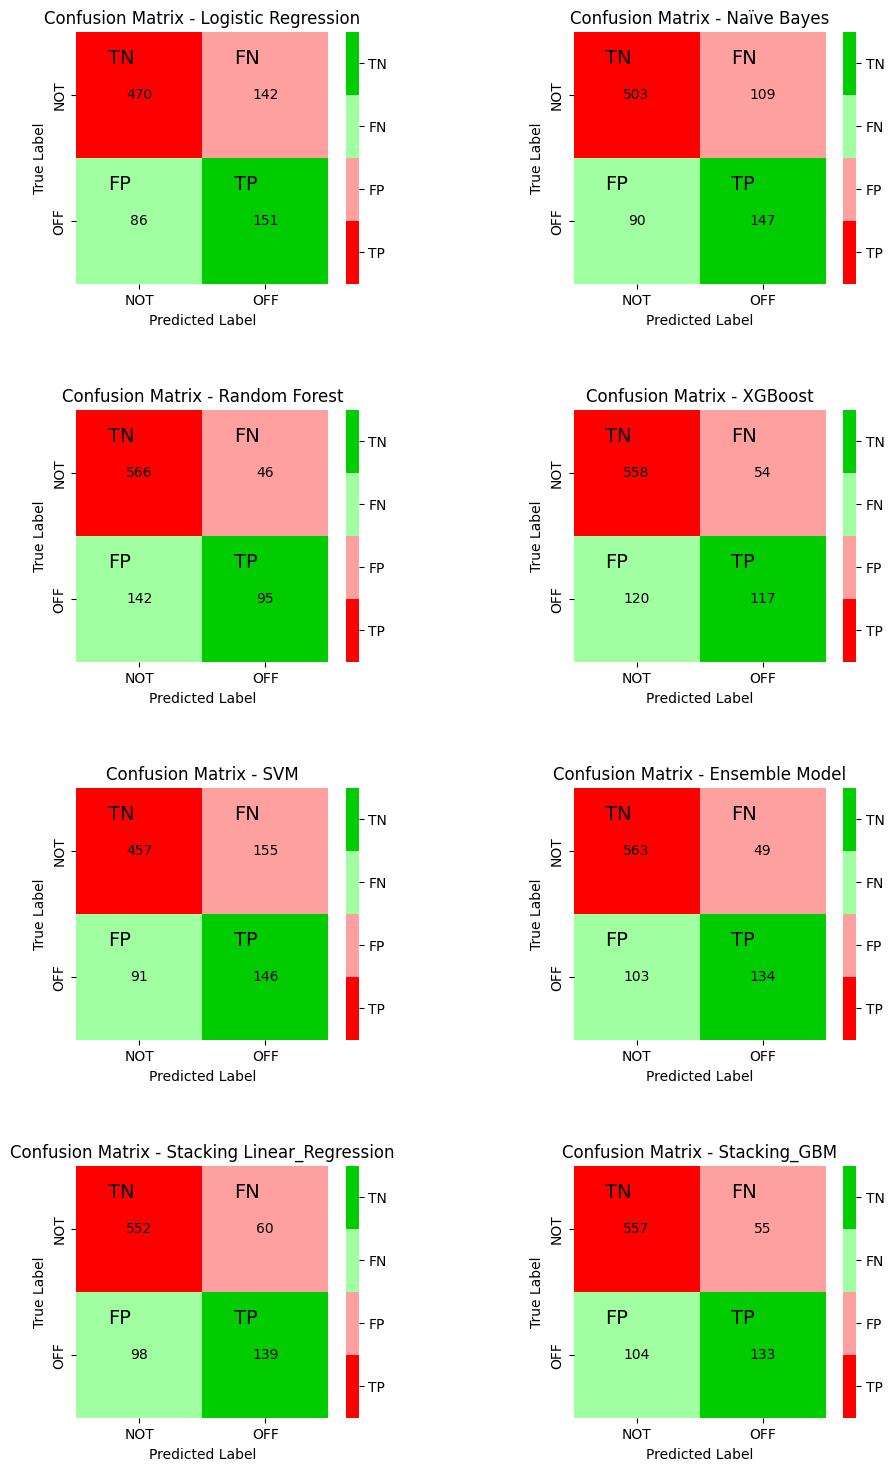

In [180]:
from matplotlib.colors import ListedColormap


class_names = ['NOT', 'OFF']

# Define custom colormap with colors in the correct order:
cmap = ListedColormap(['#FF0000', '#FFA0A0', '#A0FFA0', '#00CC00'])

# Force layout to have 2 columns (2 matrices per row)
n_models = len(confusion_matrices)
n_cols = 2  # Always 2 columns
n_rows = (n_models + 1) // 2  # Ceiling division to get number of rows needed

# Create figure with specified layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 4.5*n_rows),
                        gridspec_kw={'wspace': 0.4, 'hspace': 0.5})

# Make sure axes is always properly iterable
axes = axes.flatten() if n_rows > 1 else axes

# Plot each confusion matrix with custom colors
for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    # Create a custom matrix for color mapping
    color_indices = np.array([[0, 1], [2, 3]])

    # Plot using the color indices for mapping
    hm = sns.heatmap(color_indices, ax=axes[i], cmap=cmap,
                cbar=True, square=True, annot=cm, fmt='d',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={'color': 'black'})  # Black color for numbers, no bold

    # Customize the colorbar - reversed order to match the image
    cbar = hm.collections[0].colorbar
    cbar.set_ticks([0.375, 1.125, 1.875, 2.625])  # Center ticks in each color
    cbar.set_ticklabels(['TN', 'FN', 'FP', 'TP'][::-1])  # Reverse the order

    # Set colorbar tick label color to black
    cbar.ax.yaxis.set_tick_params(color='black')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

    # Add labels for each cell type - all in black now, no bold
    axes[i].text(0.25, 0.25, "TN", fontsize=14, color='black')
    axes[i].text(1.25, 0.25, "FN", fontsize=14, color='black')
    axes[i].text(0.25, 1.25, "FP", fontsize=14, color='black')
    axes[i].text(1.25, 1.25, "TP", fontsize=14, color='black')

    # Ensure tick labels are black
    axes[i].tick_params(colors='black')
    axes[i].xaxis.label.set_color('black')
    axes[i].yaxis.label.set_color('black')

    axes[i].set_xlabel('Predicted Label', color='black')
    axes[i].set_ylabel('True Label', color='black')
    axes[i].set_title(f'Confusion Matrix - {model_name}', color='black')

# Hide any unused subplots if we have a grid
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Ensure good spacing
plt.subplots_adjust(hspace=0.5)
plt.show()

In [181]:
def format_model_data_for_visualization(model_dictionary):

    formatted_data = []

    # Process each model in the dictionary
    for model_name, model_metrics in model_dictionary.items():
        # Create a base entry with the model name
        model_data = {"name": model_name}

        # Add top-level metrics
        for metric in ["accuracy", "precision", "recall", "f1_score","prediction"]:
            if metric in model_metrics:
                model_data[metric] = model_metrics[metric]

        # Extract class-specific metrics from classification report
        if "classification_report" in model_metrics:
            report = model_metrics["classification_report"]

            # Process each class in the report (skip summary metrics)
            for class_label, metrics in report.items():
                # Only process actual class labels (skip accuracy, macro avg, etc.)
                if isinstance(class_label, str) and class_label.isdigit():
                    # Add class-specific metrics with consistent naming
                    model_data[f"class{class_label}_precision"] = metrics["precision"]
                    model_data[f"class{class_label}_recall"] = metrics["recall"]
                    model_data[f"class{class_label}_f1"] = metrics["f1-score"]
                    model_data[f"class{class_label}_support"] = metrics["support"]

        # Add confusion matrix data if available
        if "confusion_matrix" in model_metrics:
            cm = model_metrics["confusion_matrix"]
            if isinstance(cm, list) and len(cm) >= 2:
                model_data["true_negative"] = cm[0][0]
                model_data["false_positive"] = cm[0][1]
                model_data["false_negative"] = cm[1][0]
                model_data["true_positive"] = cm[1][1]

        formatted_data.append(model_data)

    return formatted_data

In [182]:
olid_test_models_results = format_model_data_for_visualization(test_model_results)

### Accuracy bar chart

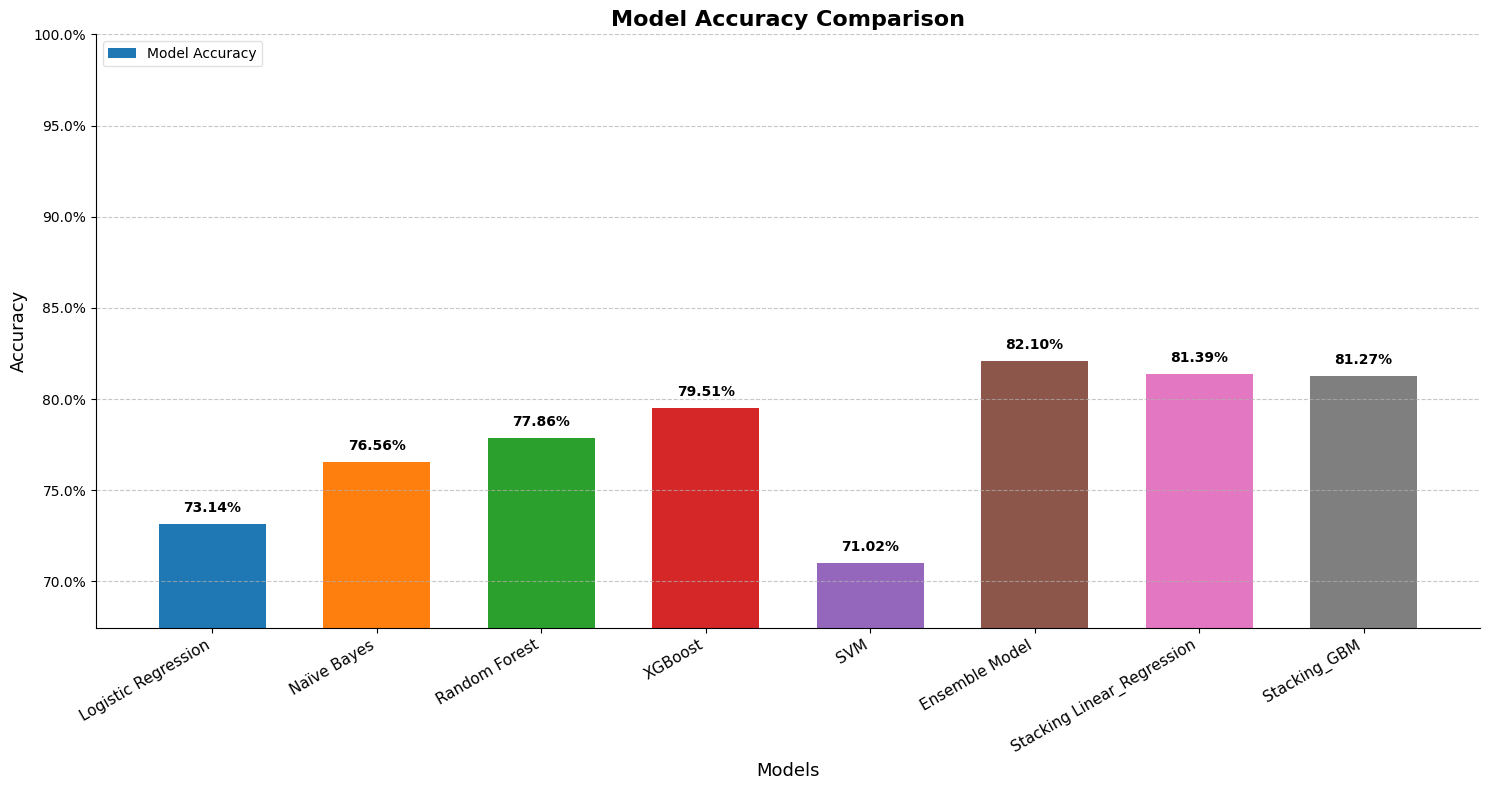

In [183]:
import matplotlib.pyplot as plt
import numpy as np


# Extract model names and accuracy values from your formatted data
model_names = [model_data['name'] for model_data in olid_test_models_results]
accuracies = [model_data['accuracy'] for model_data in olid_test_models_results]

# Create figure and axis with optimized size
fig, ax = plt.subplots(figsize=(15, 8))

# Generate colors dynamically using tab10 colormap
num_models = len(model_names)
# UPDATED LINE: Use plt.get_cmap() instead of get_cmap()
cmap = plt.get_cmap('tab10')  # Tab10 is designed for categorical data with up to 10 distinct colors
colors = [cmap(i) for i in range(num_models)]

# Create bars with the colors
bars = ax.bar(
    model_names,
    accuracies,
    color=colors,
    width=0.65
)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.005,  # Slightly closer to bar top
        f'{height:.2%}',  # Format as percentage with 2 decimal places
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10  # Slightly smaller font for 9 values
    )

# Add labels and title
ax.set_xlabel('Models', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))

# Set y-axis limits to start slightly below the minimum value and end slightly above maximum
min_acc = min(accuracies) * 0.95  # Less aggressive lower bound
max_acc = max(accuracies) * 1.05  # Less aggressive upper bound
ax.set_ylim([min_acc, max(max_acc, 1.0)])

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Improve appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-axis labels for better readability with multiple models
plt.xticks(rotation=30, ha='right', fontsize=11)

# Add a subtle box around the legend
ax.legend(['Model Accuracy'], loc='upper left', frameon=True, framealpha=0.6)

# Adjust layout for better fit
plt.tight_layout()

# Display the figure
plt.show()

### Precision,recall,f1-score and micro f1 score of every model


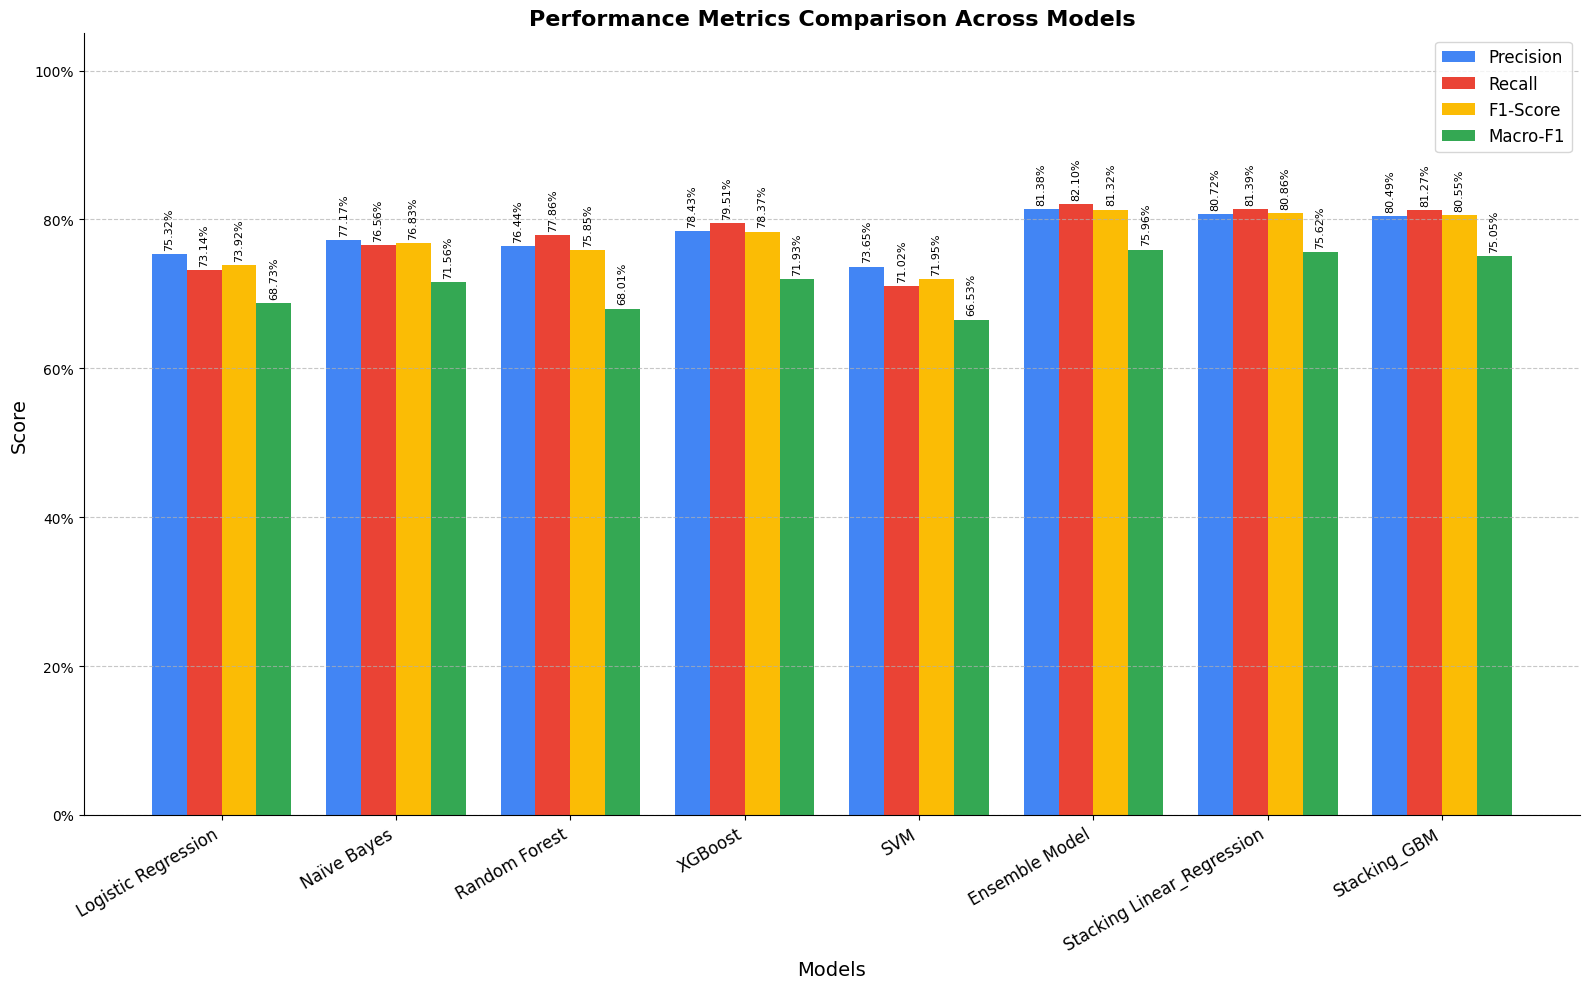

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# First, clear any existing figures
plt.clf()
plt.close('all')

# Extract model names and performance metrics
model_names = [model_data['name'] for model_data in olid_test_models_results]
precision_values = [model_data['precision'] for model_data in olid_test_models_results]
recall_values = [model_data['recall'] for model_data in olid_test_models_results]
f1_values = [model_data['f1_score'] for model_data in olid_test_models_results]

# For micro-F1, check if it exists, otherwise use regular F1
# In most cases, micro-F1 might be stored as 'f1_micro' or calculated differently
# If you don't have micro-F1, you can use the regular F1-score as a placeholder
micro_f1_values = []
for model_data in olid_test_models_results:
        micro_f1_values.append((model_data['class0_f1'] + model_data['class1_f1'])/2)


# Set up the figure with a larger size to accommodate multiple bars per model
fig, ax = plt.subplots(figsize=(16, 10))

# Set the positions of the bars on the x-axis
x = np.arange(len(model_names))
width = 0.2  # Width of each bar

# Create the bars for each metric
bars1 = ax.bar(x - width*1.5, precision_values, width, label='Precision', color='#4285F4')
bars2 = ax.bar(x - width/2, recall_values, width, label='Recall', color='#EA4335')
bars3 = ax.bar(x + width/2, f1_values, width, label='F1-Score', color='#FBBC05')
bars4 = ax.bar(x + width*1.5, micro_f1_values, width, label='Macro-F1', color='#34A853')

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Performance Metrics Comparison Across Models', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=30, ha='right', fontsize=12)
ax.legend(fontsize=12)

# Format y-axis
ax.set_ylim([0, 1.05])  # Scores typically range from 0 to 1
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Improve appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Function to add value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

# Add value labels to all bars
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

# Ensure good spacing
plt.tight_layout()

# Display the figure
plt.show()

### ROC curve

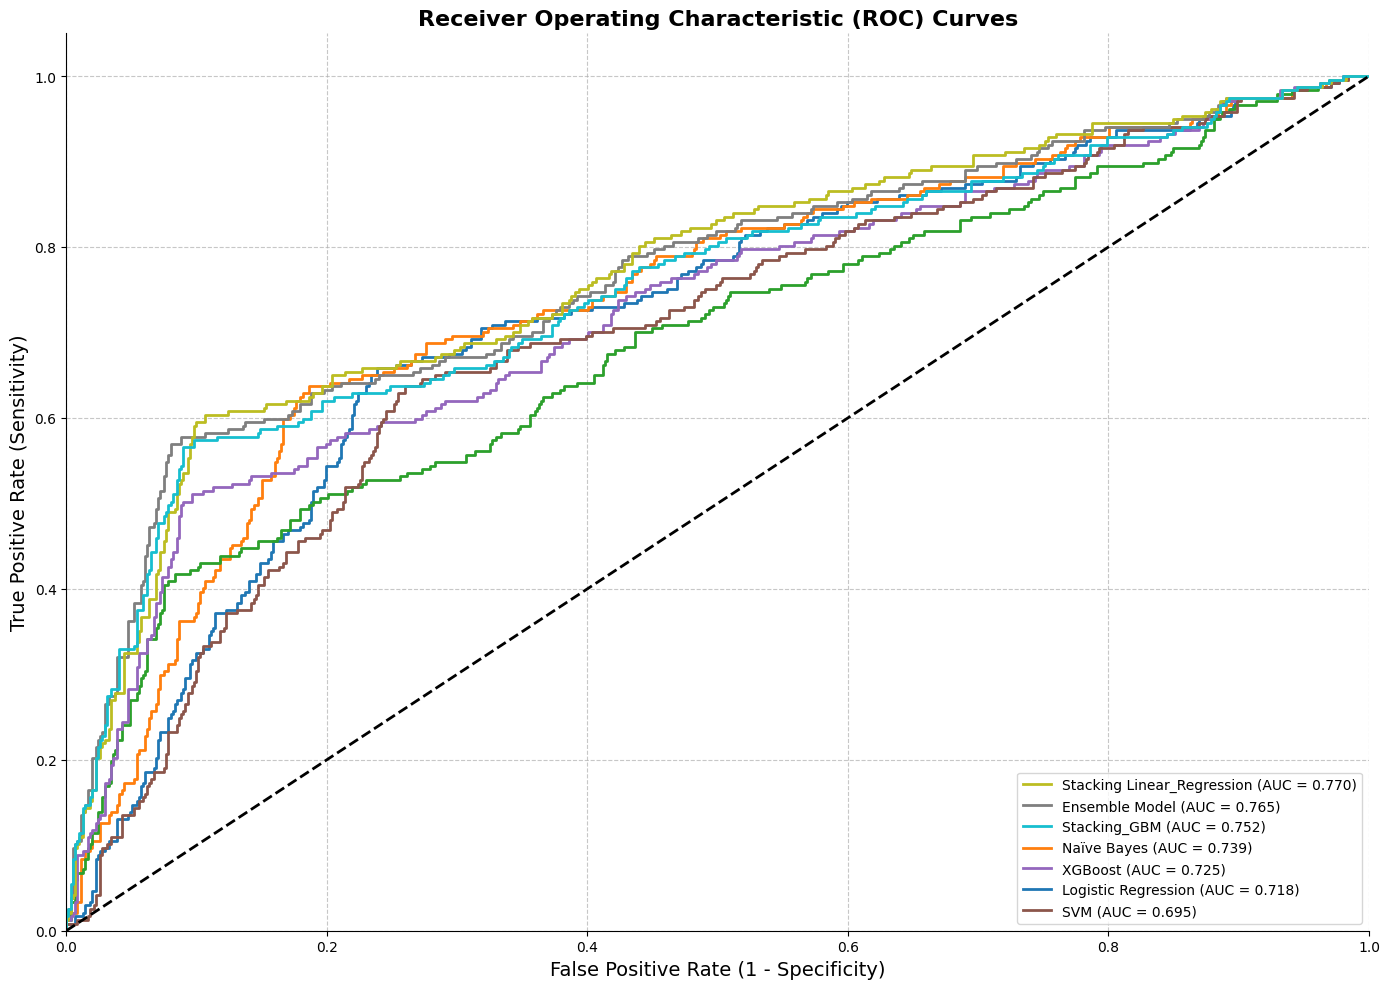

In [185]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Clear any existing figures
plt.clf()
plt.close('all')
plt.figure(figsize=(14, 10))

# Get the true labels
y_true = y_test_df['subtask_a'].values

# Colors for the different models
colors = plt.cm.tab10(np.linspace(0, 1, len(olid_test_models_results)))
auc_values = []

# Loop through each model
for i, model_data in enumerate(olid_test_models_results):
    model_name = model_data['name']

    try:
        y_pred = model_data['prediction']
        np.random.seed(42)  # For reproducibility
        y_score = y_pred + np.random.normal(0, 0.01, size=len(y_pred))

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        auc_values.append((model_name, roc_auc))

        # Plot the ROC curve with interpolation for smoothness
        plt.plot(fpr, tpr, lw=2, color=colors[i],
                 label=f'{model_name} (AUC = {roc_auc:.3f})')

    except Exception as e:
        print(f"Error generating ROC curve for {model_name}: {str(e)}")

# Add the random classifier reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16, fontweight='bold')

# Sort and add the legend
if auc_values:
    auc_values.sort(key=lambda x: x[1], reverse=True)
    sorted_labels = [f"{name} (AUC = {auc:.3f})" for name, auc in auc_values]
    handles, labels = plt.gca().get_legend_handles_labels()

    # Create dictionary mapping labels to indices
    label_dict = {label: i for i, label in enumerate(labels) if "Random" not in label}

    # Create ordered list of indices
    order = []
    for name, auc in auc_values:
        for label, idx in label_dict.items():
            if name in label:
                order.append(idx)
                break

    # Create sorted legend
    plt.legend([handles[i] for i in order], [labels[i] for i in order],
               loc="lower right", fontsize=10)
else:
    plt.legend(loc="lower right", fontsize=10)

# Add grid and improve appearance
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Use a curve interpolation method for smoother appearance
plt.tight_layout()
plt.show()